In [1]:
from astropy.io import fits
from astropy.stats import biweight_midvariance as bwmv
from astropy.stats import median_absolute_deviation as mad
import astroalign as aa
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation
# Shift the image
from scipy.ndimage import shift
import pandas as pd
import os

def fitsread(f, header=False):
    with fits.open(f) as hdul:
        data = hdul[0].data
        if header:
            h = hdul[0].header
            return data, h
        else:
            return data
        
def rescale(image, mref, sref, roi=None):
    imageV = image if roi is None else image[roi]
    m1 = np.median(imageV)
    s1 = mad(imageV)
    ki = sref/s1
    rimage = ki*(image - m1) + mref
    return rimage

IndentationError: unexpected indent (<ipython-input-1-599dbed97a42>, line 19)

In [ ]:
# Masters
cal_dir = Path(os.environ['DATA'], 'DDS', 'Taka', 'Calibration')
dark600f = Path(cal_dir, 'masterDark600_bin1_median_Jan_2019.fits')
HFlatf = Path(cal_dir, 'masterHFlat_bin1_Mar_3_2019.fits')
print(str(cal_dir), cal_dir.exists())
# Load master files - Dark is not Bias-subtracted, but Master flat is bias-subtracted. 
Dark = fitsread(dark600f)
HFlat = fitsread(HFlatf)

In [ ]:
# Lights
lights_dir = Path(os.environ['DATA'], 'DDS', 'Taka', 'Lights', 'IC_1805')
Hlights_dir = Path(lights_dir, 'H')
print(str(Hlights_dir), Hlights_dir.exists())
Hlightsf = sorted(Hlights_dir.rglob('H*.fit'))
print('number of lights: ', len(Hlightsf))
# Load 1st image to get reference statistics
im0 = fitsread(Hlightsf[0])
# image size
sz = im0.shape
# Field of view for a sample to compute statistical moments faster.
tfov0 = np.s_[:, -512:, -512]
fov0 = tfov0[1:]
# Reference statistical moments
m0 = np.median(im0[fov0])
s0 = mad(im0[fov0])

### Make visual selection / rejection

In [ ]:
fov = np.s_[1500:1500+512, 2000:2000+512]
vmin = np.percentile(im0, 0.1)
vmax = np.percentile(im0, 99.7)
for f in Hlightsf[0:1]:
    light = fitsread(f)
    light2 = rescale(light, m0, s0, fov0)
    plt.figure(figsize=(5,5))
    plt.imshow(light2[fov], vmin=vmin, vmax=vmax, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
#     plt.savefig(Path(lights_dir, 'H', 'jpegs', f'{f.stem}.jpg'), bbox_inches = 'tight', pad_inches = 0)
#     plt.close()

In [ ]:
# Uncomment for to work on a selection with Maxselector excel file. 
# Hf = dfh[(dfh['Fwhm'] <= 4.6) & (dfh['Rnd'] < 7) & (dfh['BackG'] < 900)].reset_index(drop=True)['File'].apply(lambda x: Path(lights_dir, 'H', x)).sort_values().tolist()

### Load selected files upon rejection from above jpeg previews (and optionally Maxselector)

In [ ]:
Hlightsf = sorted(Hlights_dir.rglob('H*.fit'))
selectf = Path(Hlights_dir, 'selection.txt')
with open(selectf) as file: lines = [line.rstrip('\n') for line in file]
print('index of rejected file index: ', lines)
print('Nb of selected files: ', len(Hlightsf) - len(lines))
Hf = [f for f in Hlightsf if not any(x in str(f) for x in lines)]

In [ ]:
# Load lights from curated list
HLights = np.array([fitsread(f) for f in Hf])
HLights.shape

In [ ]:
HCal1 = HLights - Dark
# HCal1[HCal1 <0] = 0
HCal1V = HCal1[tfov0]

In [ ]:
# Flat Field and bring back to pre-Flat-field equivalent histograms
HCal2 = (HCal1 / HFlat).astype(np.float32)
HCal2V = HCal2[tfov0]

In [10]:
# Export calibrated files to FITS files
for i, f in enumerate(Hf):
    fits.writeto(Path(Hlights_dir, 'calibrated', f'cal.{f.stem}.fits'), HCal2[i].astype(np.float32), overwrite=True)

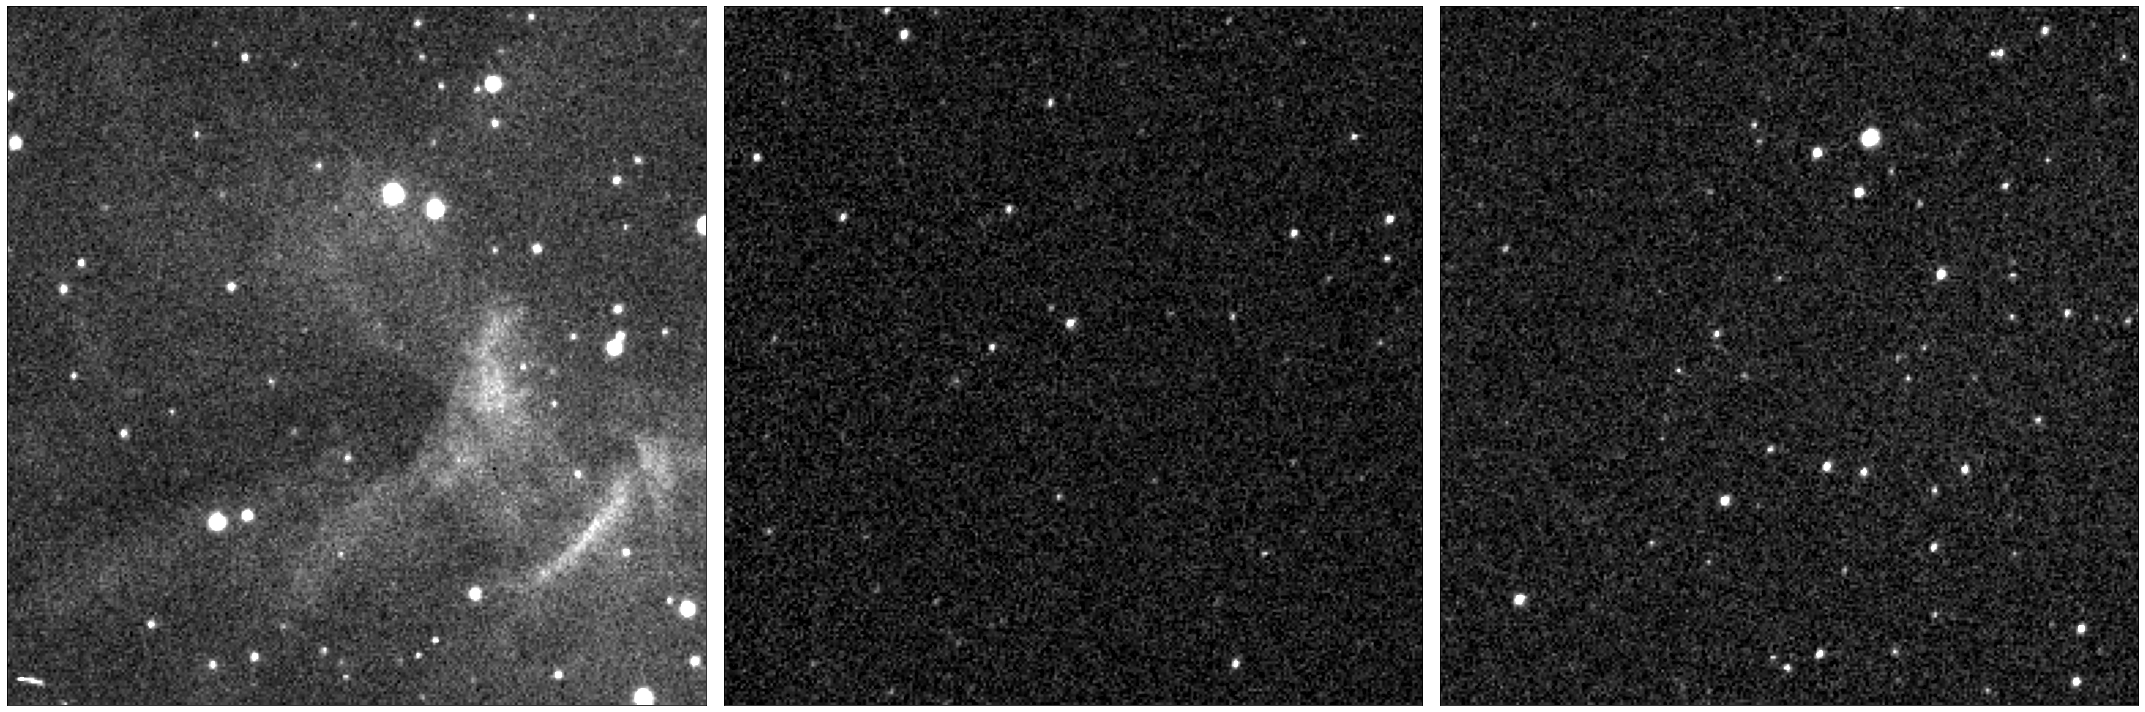

In [11]:
Hregdir = Path(Hlights_dir, 'registered')
Hregdir.mkdir(parents=False, exist_ok=True)

fov = np.s_[1500:1500+256, 2000:2000+256]
fov2 = np.s_[0:256, 0:256]
fov3 = np.s_[-256:, -256:]

# Rescale the reference image
# m2 = np.median(HCal2V[0])
# s2 = mad(HCal2V[0])
# ki = s1/s2
# ref = ki*(HCal2[0] - m2) + m1
mref = np.median(HCal1V[0])
sref = mad(HCal1V[0])
ref = rescale(HCal2[0], mref, sref, fov0)

vmin = 0
vmax = np.percentile(HCal1V[0], 99.9)

for i, f in enumerate(Hf[0:1]):
    
    image2 = HCal2[i]
    
#     # Specify the number of iterations.
#     number_of_iterations = 100;
#     # Specify the threshold of the increment
#     # in the correlation coefficient between two iterations
#     termination_eps = 1e-3;
#     # Define the motion model
#     warp_mode = cv2.MOTION_EUCLIDEAN
#     # Define termination criteria
#     criteria = (cv2.TERM_CRITERIA_EPS, number_of_iterations,  termination_eps)
#     warp_matrix2 = np.eye(2, 3, dtype=np.float32)
#     # Run the ECC algorithm. The results are stored in warp_matrix.
#     med2 = np.median(HCal2[i])
#     std2 = HCal2[i].std()
#     im2 = (HCal2[i] - med2)/std2
#     (cc, warp_matrix2) = cv2.findTransformECC(ref2, im2, warp_matrix2, warp_mode, criteria, inputMask=None, gaussFiltSize=1)
#     imshifts2.append(warp_matrix2)
#     image2 = cv2.warpAffine(HCal2[i], warp_matrix2, (sz[1],sz[0]), flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP);
    

    image2 = rescale(image2, mref, sref, fov0)
    
    p, (pos_img, pos_img_rot) = aa.find_transform(image2, ref)
    image2 = cv2.warpPerspective(image2, p.params, (sz[1],sz[0]), flags=cv2.INTER_CUBIC);
    fits.writeto(Path(Hregdir, f'reg.{f.stem}.fits'), image2.astype(np.float32), overwrite=True)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    axs[0].imshow(image2[fov], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[1].imshow(image2[fov2], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[2].imshow(image2[fov3], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    axs[1].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    axs[2].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    plt.tight_layout()
#     plt.savefig(Path(lights_dir, 'H', 'registered', 'jpegs', f'{f.stem}.reg.aa.jpg'))
#     plt.close()

In [12]:
Hregf = sorted(Hregdir.rglob('reg*.fits'))
len(Hregf)

46

In [13]:
Hreg = np.array([fitsread(f) for f in Hregf])

In [14]:
Hstackmed = np.median(Hreg, axis=0)

In [15]:
fits.writeto(Path(lights_dir, 'stacked', 'Hstackmed.fits'), Hstackmed.astype(np.float32), overwrite=True)

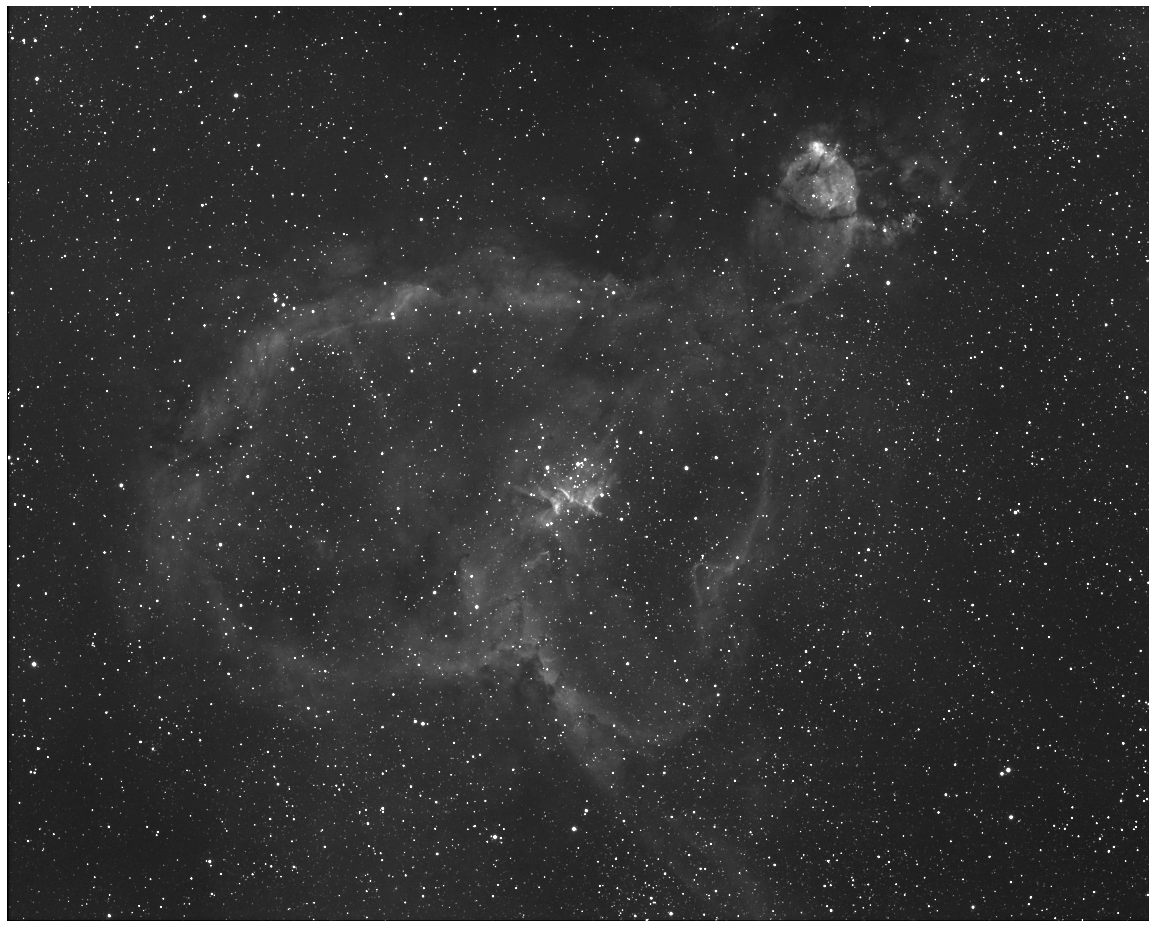

In [16]:
plt.figure(figsize=(20,13))
plt.imshow(Hstackmed, vmin=np.percentile(Hstackmed, 0.1), vmax=np.percentile(Hstackmed, 99.7), origin='lower', cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked', 'Hstackmed.jpg'), bbox_inches = 'tight', pad_inches = 0)

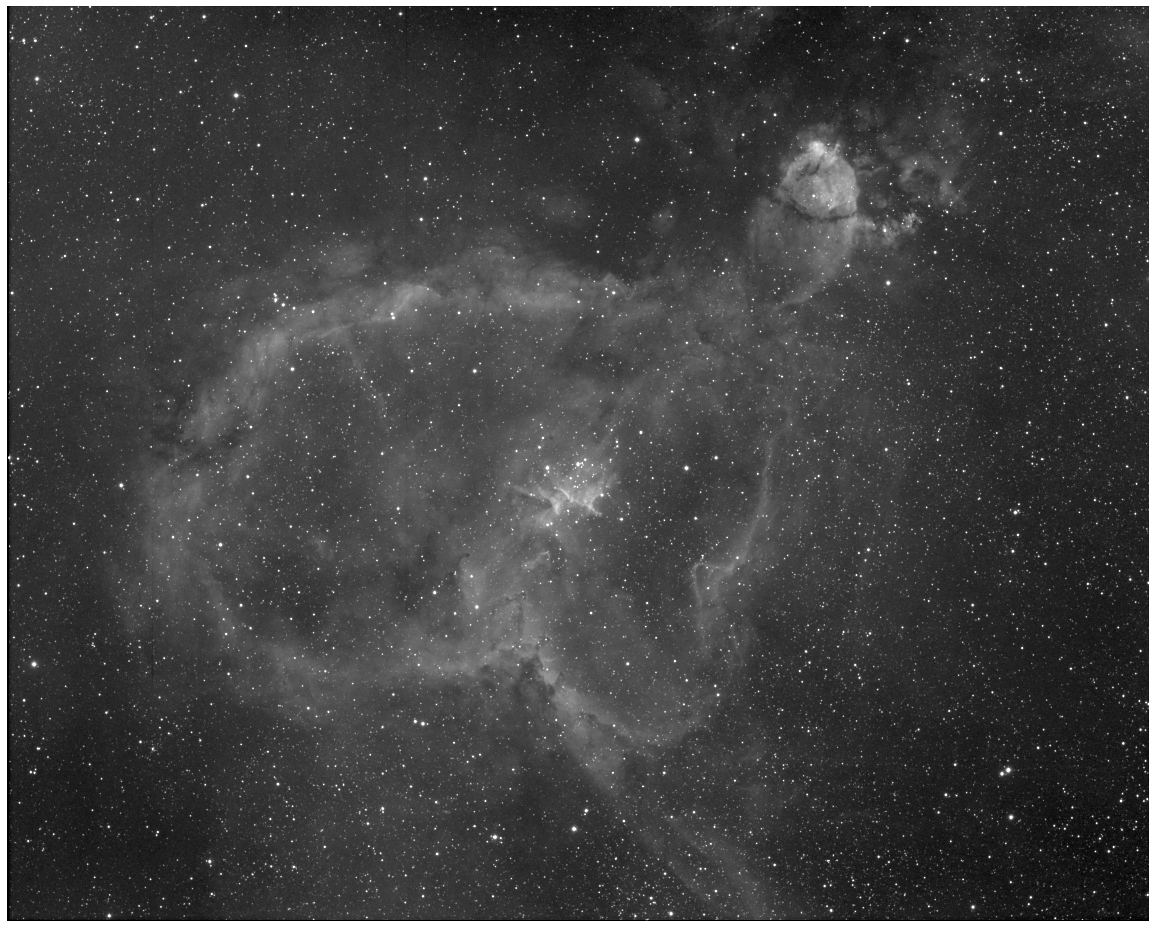

In [17]:
Hstackmed2 = np.arcsinh(Hstackmed)
plt.figure(figsize=(20,13))
plt.imshow(Hstackmed2, vmin=np.percentile(Hstackmed2, 0.7), vmax=np.percentile(Hstackmed2, 99.8), origin='lower', cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked', 'Hstackmed_asinh.jpg'), bbox_inches = 'tight', pad_inches = 0)